In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from full_fred.fred import Fred
from functools import reduce
import statsmodels.tsa.stattools as ss 
from statsmodels.tsa.api import VAR
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
fred = Fred('API_key.txt')

#### Commodities:

Global commodity prices for various categories in USD 
Data source:FRED ECONOMIC DATA ST.LOUIS FED DATABASE

In [3]:
# Global commodity prices for various categories in USD 
# (Main Data source:FRED ECONOMIC DATA ST.LOUIS FED DATABASE)

Soft = {'PWHEAMTUSDM':'Wheat',
        'PMAIZMTUSDM':'Corn',
        'PSOYBUSDQ':'Soybeans',
        'PSOILUSDM':'Soybean Oil',
        'PSMEAUSDM':'Soybean Meal',
        'PRICENPQUSDM':'Rice',
        'PCOCOUSDM':'Cocoa',
        'PCOFFOTMUSDM':'Coffee',
        'PCOTTINDUSDM':'Cotton',
        'PSUGAISAUSDM':'Sugar'} 

Energy = {'POILWTIUSDM':'WTI Crude',
          'POILBREUSDM':'Brent Crude',
          'PNGASUSUSDM':'Natural Gas',
          'PURANUSDM':'Uranium'}

# For medals, data are collected from the Yahoo Finance API instead of 
# FRED ECONOMIC DATA ST.LOUIS FED DATABASE
Metal =  {'GC=F':'Gold',
          'PL=F':'Platinum',
          'PA=F':'Palladium',
          'SI=F':'Silver'}

Industrial = {'PCOPPUSDM':'Copper',
              'PLEADUSDM':'Lead',
              'PZINCUSDM':'Zinc',
              'PTINUSDM':'Tin',
              'PALUMUSDM':'Aluminium',
              'PNICKUSDM':'Nickel',
              'PIORECRUSDM':'Iron Ore'}

Others =  {'PRUBBUSDM':'Rubber',
           'PPOILUSDM':'Palm Oil', 
           'PWOOLFUSDM':'Wool'}


In [194]:
Combined = {**Soft , **Energy, **Industrial, **Others}

In [4]:
# Percentage Changes of commodity prices
def get_commodity_prices(_dict):
    _ind = []
    for i in _dict.keys():
        dd = fred.get_series_df(i).rename(
             columns={'value':_dict[f'{i}']})[
             ['date',_dict[f'{i}']]].replace('.',np.nan)
        dd[_dict[f'{i}']] = 100*dd[_dict[f'{i}']].astype(float).pct_change()
        dd['date'] = pd.to_datetime(dd['date'])
        dd = dd.dropna() 
        _ind.append(dd)

    final = reduce(lambda left,right: 
                    pd.merge(left,right,on=['date'],), 
                    _ind)
    return final



In [5]:
# Medal Prices:

_m_ind = []
for i in Metal.keys():
        pp = yf.download(i, period="max",interval='1mo').reset_index().rename(
        columns={'Date':'date','Adj Close':Metal[f'{i}']})[['date',Metal[f'{i}']]]
        pp['date'] = pd.to_datetime(pp['date'])
        pp[Metal[f'{i}']] = 100*(pp[Metal[f'{i}']].astype(float).pct_change())
        pp = pp.dropna()
        _m_ind.append(pp)

metal_commodities = reduce(lambda left,right: 
                    pd.merge(left,right,on=['date'],), 
                    _m_ind)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [6]:
# Changes of commodity prices
soft_commodities = get_commodity_prices(Soft)
energy_commodities = get_commodity_prices(Energy)
industrial_commodities = get_commodity_prices(Industrial)
other_commodities = get_commodity_prices(Others)

#### Driving factors of Commodity prices

- Federal Funds Effective Rate (DFF)
- Global GDP GROWTH
- Global inflation rates

In [7]:
# OECD GDP Growth rate
world_gdp = pd.read_csv('gdp_OECD.csv')
oecd_gdp_gr = world_gdp[(world_gdp.LOCATION=='OECD')&
          (world_gdp.FREQUENCY=='Q')&
          (world_gdp.SUBJECT=='TOT')].rename(columns={'TIME':'date',
          'Value':'OECD_gdp_growth'}).reset_index()[
           ['date','OECD_gdp_growth']]
oecd_gdp_gr['date'] = pd.to_datetime(oecd_gdp_gr['date'])
oecd_gdp_gr['OECD_gdp_growth'] = 100*(oecd_gdp_gr['OECD_gdp_growth'].astype(float).pct_change())
oecd_gdp_gr = oecd_gdp_gr.dropna()

# OECD Inflation
world_inflation = pd.read_csv('inflation_OECD.csv')
oecd_inflation = world_inflation[(world_inflation.LOCATION=='OECD')&
          (world_inflation.FREQUENCY=='Q')&
          (world_inflation.SUBJECT=='TOT')].rename(columns={'TIME':'date',
          'Value':'OECD_inflation'}).reset_index()[
           ['date','OECD_inflation']]
oecd_inflation['date'] = pd.to_datetime(oecd_inflation['date'])
oecd_inflation['OECD_inflation'] = 100*(oecd_inflation['OECD_inflation'].astype(float).pct_change())
oecd_inflation = oecd_inflation.dropna()

# US Interest Rate
US_intrate = fred.get_series_df('DFF').rename(
             columns={'value':'US_int_rate'})[
             ['date','US_int_rate']].replace('.',np.nan)
US_intrate['US_int_rate'] = 100*(US_intrate['US_int_rate'].astype(float).pct_change())
US_intrate['date'] = pd.to_datetime(US_intrate['date'])
US_intrate = US_intrate.dropna() 


driving_factors = reduce(lambda left,right: 
                    pd.merge(left,right,on=['date'],), 
                    [oecd_gdp_gr, oecd_inflation, 
                    US_intrate]).dropna()

In [8]:
soft_commodities_final = soft_commodities.merge(driving_factors, on='date')
energy_commodities_final = energy_commodities.merge(driving_factors, on='date')
industrial_commodities_final = industrial_commodities.merge(driving_factors, on='date')
other_commodities_final = other_commodities.merge(driving_factors, on='date')
metal_commodities_final = metal_commodities.merge(driving_factors, on='date') 

#### Stationarity Tests of Endogenous Variables

In [9]:
def ADF_test(df):
    adf = pd.DataFrame([[
               ss.adfuller(df[i])[0],
               ss.adfuller(df[i])[1],i] 
               for i in df.columns[1:]], 
               columns=['ADF Statistic:',
                        'p-value',
                        'Indicator']).round(3)
    return adf

In [10]:
ADF_test(soft_commodities)

,ADF Statistic:,p-value,Indicator
0,-12.332,0.0,Wheat
1,-9.168,0.0,Corn
2,-8.582,0.0,Soybeans
3,-11.985,0.0,Soybean Oil
4,-8.843,0.0,Soybean Meal
5,-12.093,0.0,Rice
6,-6.625,0.0,Cocoa
7,-12.248,0.0,Coffee
8,-4.589,0.0,Cotton
9,-6.287,0.0,Sugar


In [11]:
ADF_test(energy_commodities)

,ADF Statistic:,p-value,Indicator
0,-13.186,0.0,WTI Crude
1,-12.970,0.0,Brent Crude
2,-5.871,0.0,Natural Gas
3,-11.823,0.0,Uranium


In [13]:
ADF_test(industrial_commodities)

,ADF Statistic:,p-value,Indicator
0,-13.109,0.0,Copper
1,-15.826,0.0,Lead
2,-14.028,0.0,Zinc
3,-10.292,0.0,Tin
4,-14.699,0.0,Aluminium
5,-14.256,0.0,Nickel
6,-16.523,0.0,Iron Ore


In [14]:
ADF_test(other_commodities)

,ADF Statistic:,p-value,Indicator
0,-14.735,0.0,Rubber
1,-4.872,0.0,Palm Oil
2,-15.325,0.0,Wool


In [15]:
ADF_test(metal_commodities)

,ADF Statistic:,p-value,Indicator
0,-11.730,0.0,Gold
1,-13.911,0.0,Platinum
2,-8.845,0.0,Palladium
3,-16.304,0.0,Silver


In [19]:
ADF_test(driving_factors)

,ADF Statistic:,p-value,Indicator
0,-15.583,0.000,OECD_gdp_growth
1,-13.653,0.000,OECD_inflation
2,-2.539,0.106,US_int_rate


#### VAR Models

In [20]:
def get_dynamic_responses(df):
    tmp_col = df.drop(
      columns=['date','OECD_gdp_growth',
      'OECD_inflation','US_int_rate'])
    
    dynamic_responses = []
    for comm in tmp_col:
        model = VAR(df[[comm,'OECD_gdp_growth',
                        'OECD_inflation','US_int_rate']])
        energy_results = model.fit(maxlags=11, ic='aic')
        _irf = energy_results.irf(21)
        #tmp_df = pd.DataFrame([_irf.cum_effects[k][0] for k in range(21)], 
        #         columns=[f'{comm}-{comm}',f'OECD_gdp_growth-{comm}',
        #         f'OECD_inflation-{comm}',f'US_int_rate-{comm}'])
        tmp_df = pd.DataFrame([_irf.orth_cum_effects[k][0] for k in range(21)], 
                 columns=[f'{comm}-{comm}',f'OECD_gdp_growth-{comm}',
                 f'OECD_inflation-{comm}',f'US_int_rate-{comm}'])
        
        dynamic_responses.append(tmp_df)
    
    return pd.concat(dynamic_responses,axis=1)


#### Dynamic Responses Output Shock

In [69]:
def graph_responses(df,endog,name,shock):
    df1 = get_dynamic_responses(df)
    df1 = df1[[i for i in df1.columns if (f'{endog}') in i]]
    plt.figure(figsize=(6,3),dpi=200)
    sns.set_theme(style="whitegrid",font_scale=1)
    sns.lineplot(data=df1,palette='icefire',linewidth = 4,
             markers=True,dashes=False).set(title=f"""
             Cumulative Dynamic Responses of {name}
             Commodities given a Positive {shock} Shock
             """,xlabel='periods',ylabel='%')
    sns.lineplot(data=[0]*21, color='darkred', linewidth=3)
    plt.legend(labels=df.drop(columns=['date','OECD_gdp_growth',
               'OECD_inflation','US_int_rate']).columns.tolist(),
               bbox_to_anchor=(1.35,0), loc='lower right') 


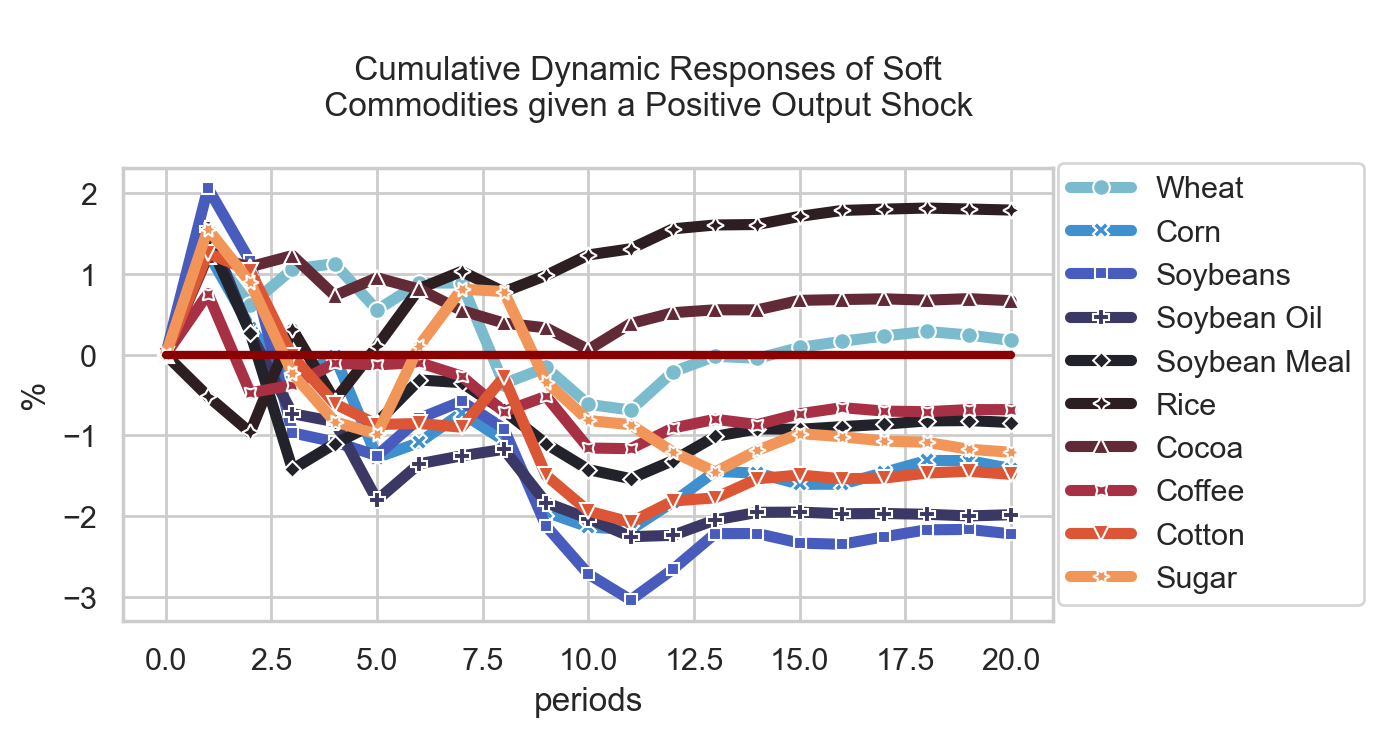

In [70]:
graph_responses(soft_commodities_final,'gdp','Soft','Output')

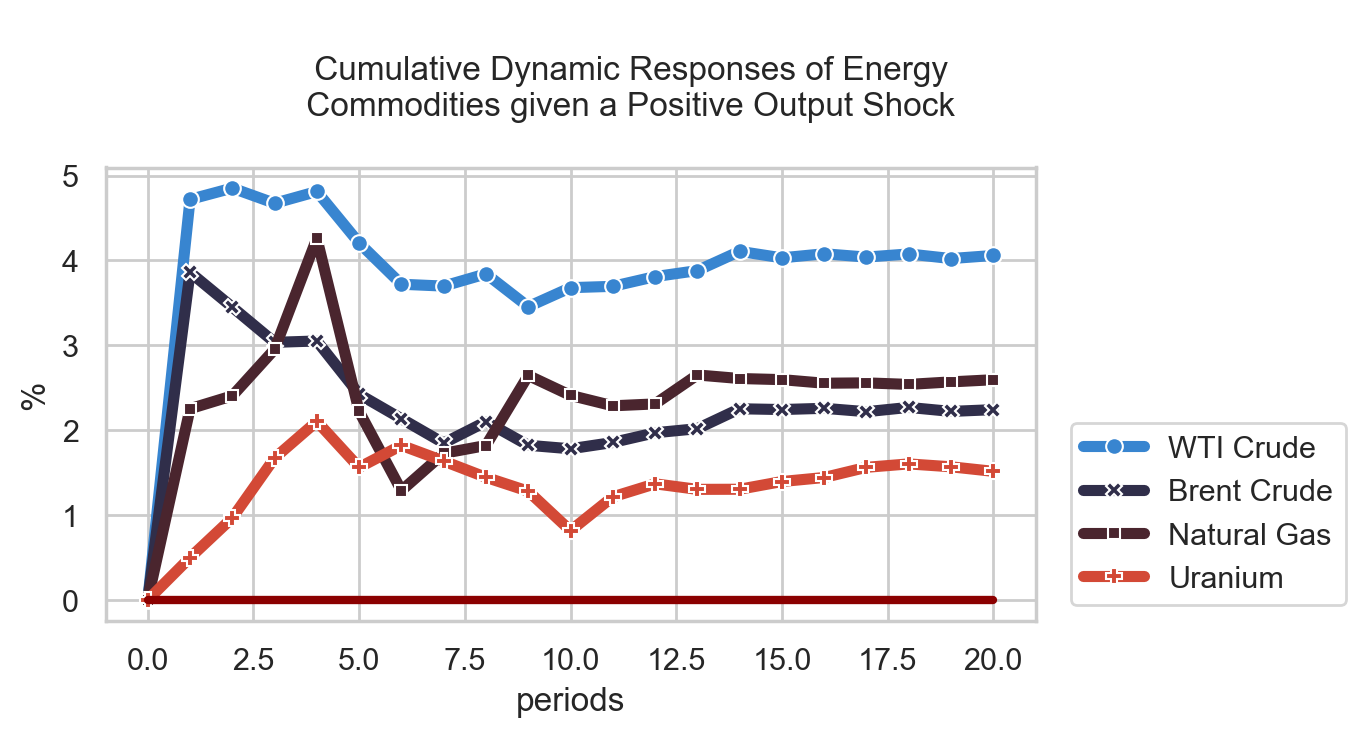

In [71]:
graph_responses(energy_commodities_final,'gdp','Energy','Output')

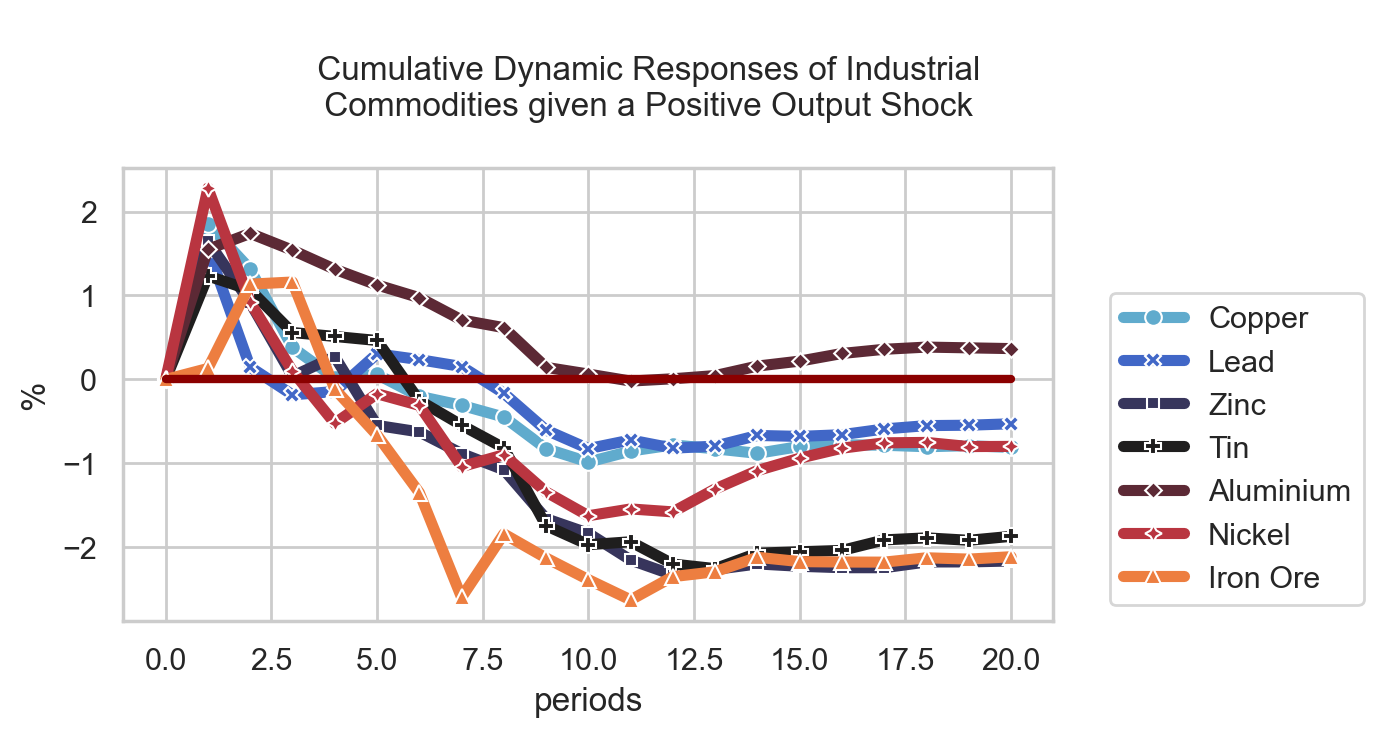

In [72]:
graph_responses(industrial_commodities_final,'gdp','Industrial','Output')

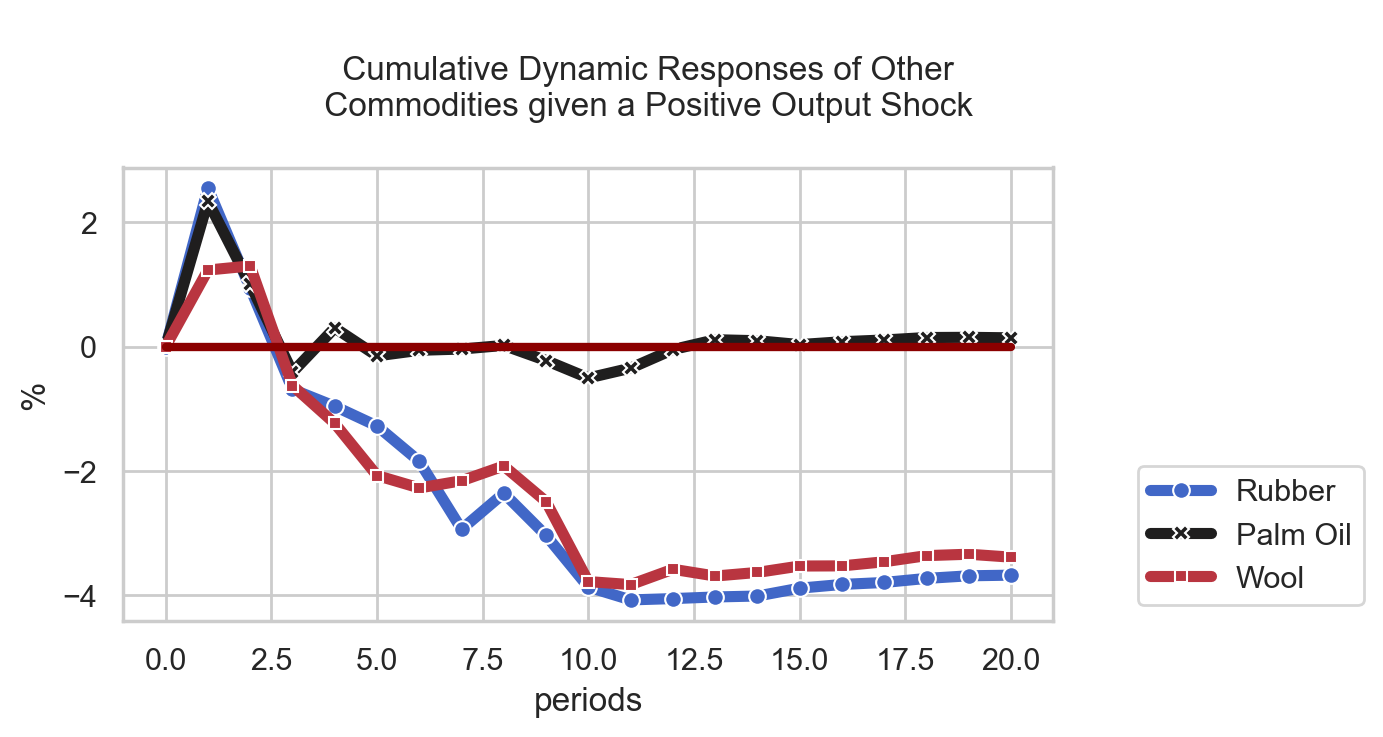

In [73]:
graph_responses(other_commodities_final,'gdp','Other','Output')

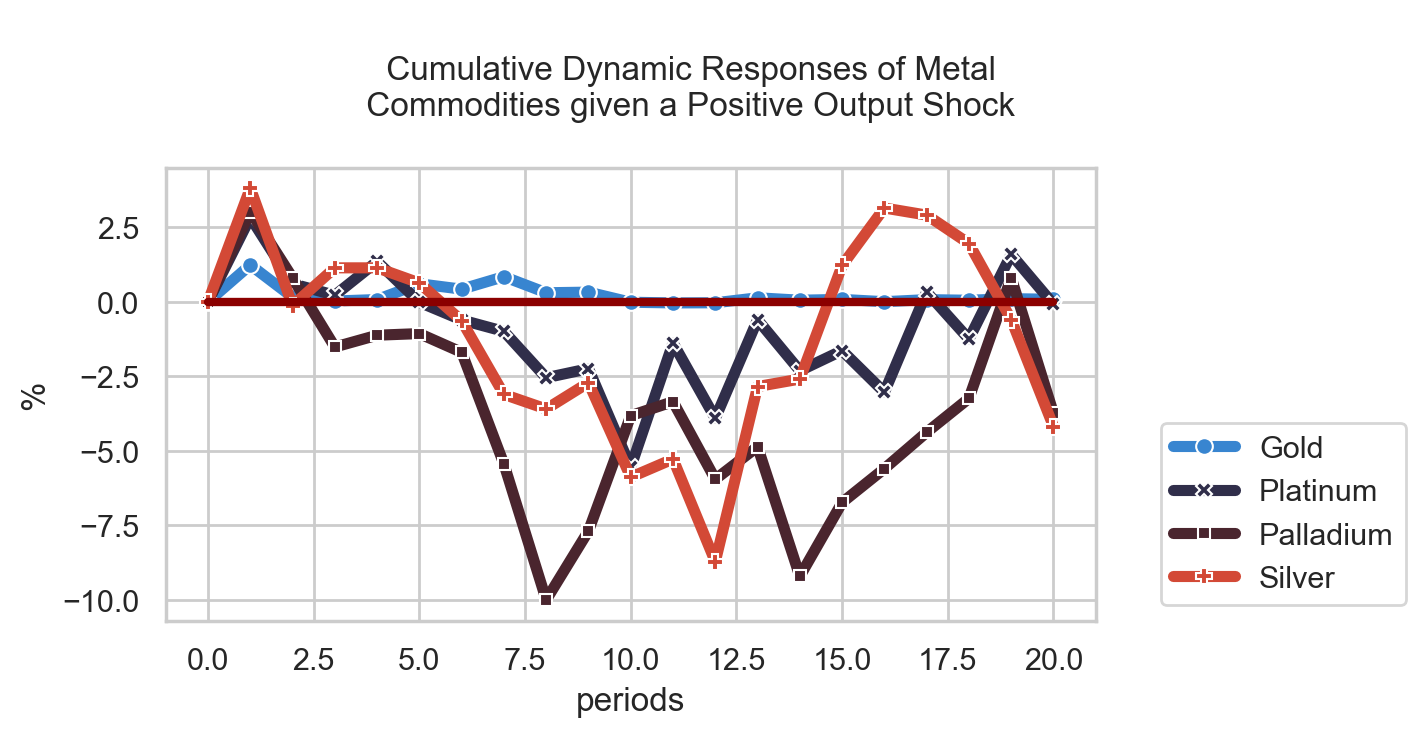

In [74]:
graph_responses(metal_commodities_final,'gdp','Metal','Output')

#### Dynamic Responses Inflation

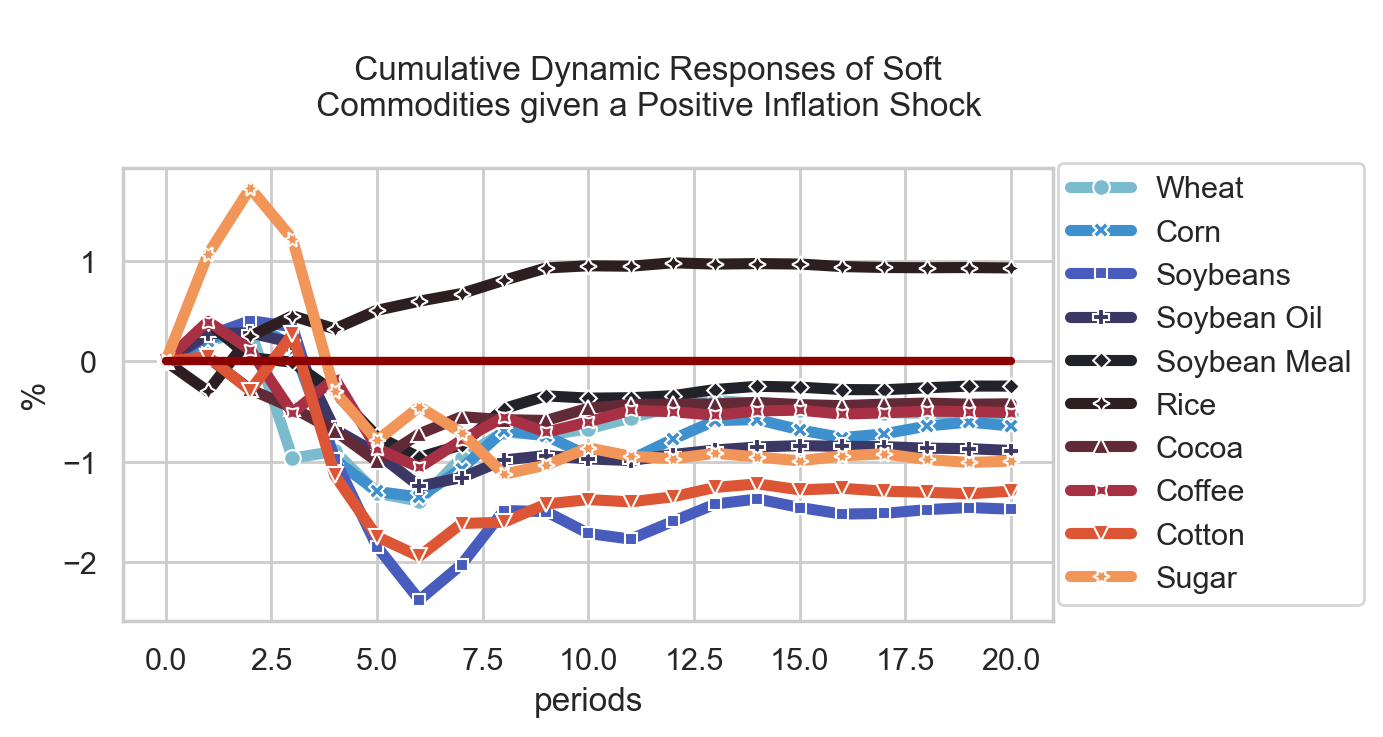

In [75]:
graph_responses(soft_commodities_final,'inflation','Soft','Inflation')

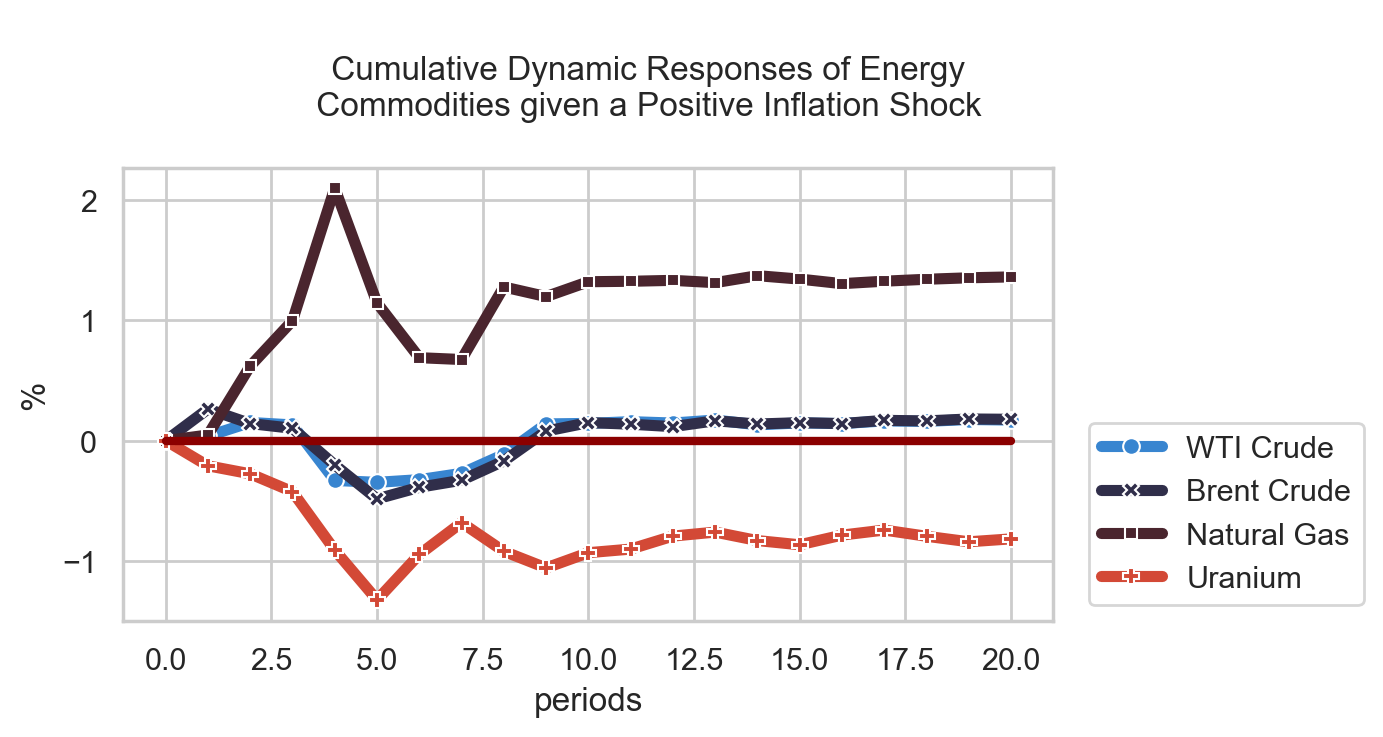

In [76]:
graph_responses(energy_commodities_final,'inflation','Energy','Inflation')

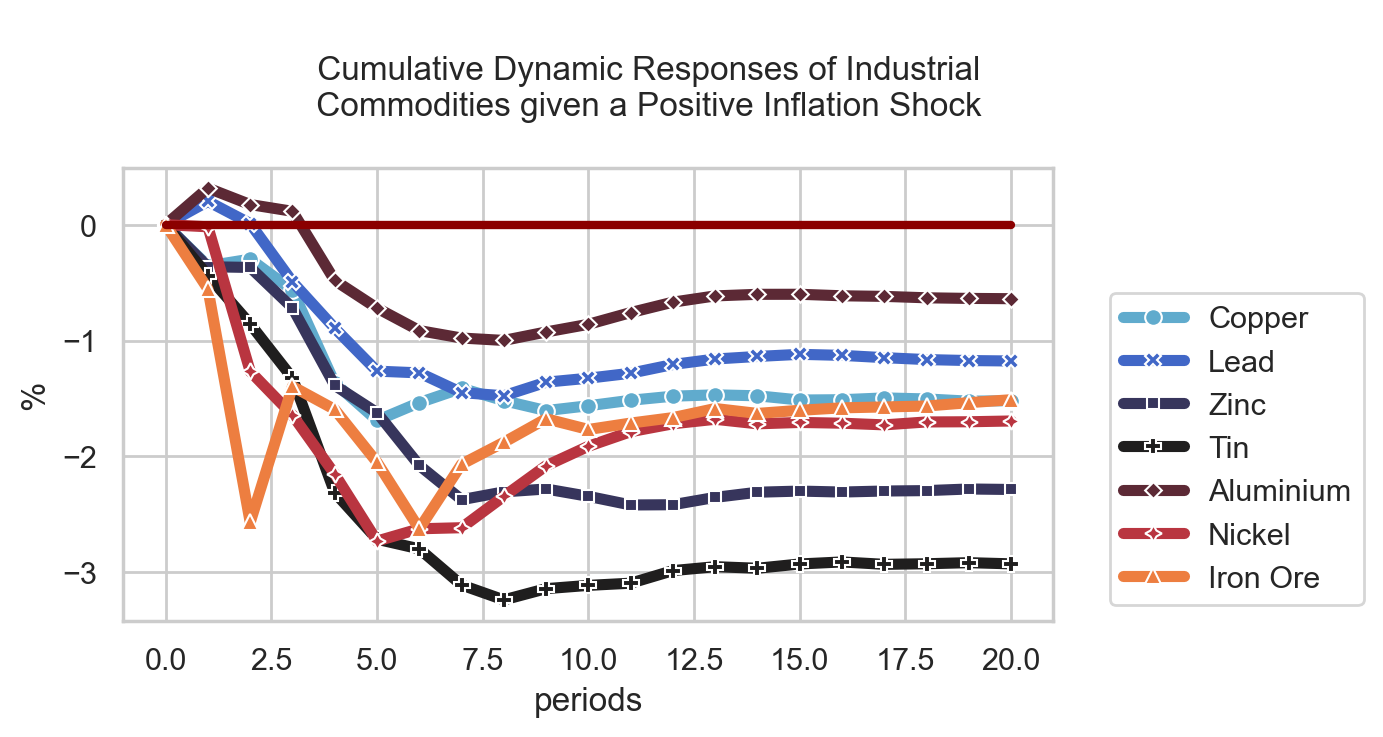

In [77]:
graph_responses(industrial_commodities_final,'inflation','Industrial','Inflation')

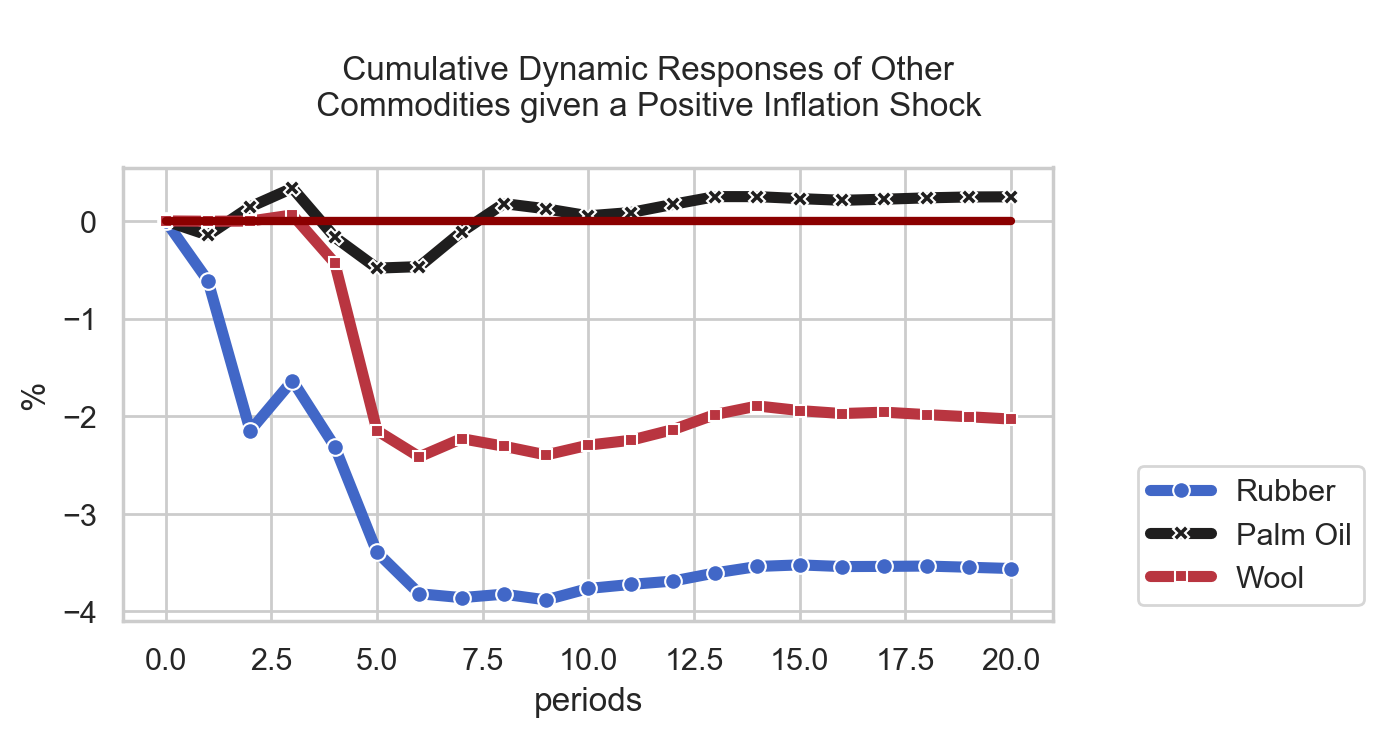

In [78]:
graph_responses(other_commodities_final,'inflation','Other','Inflation')

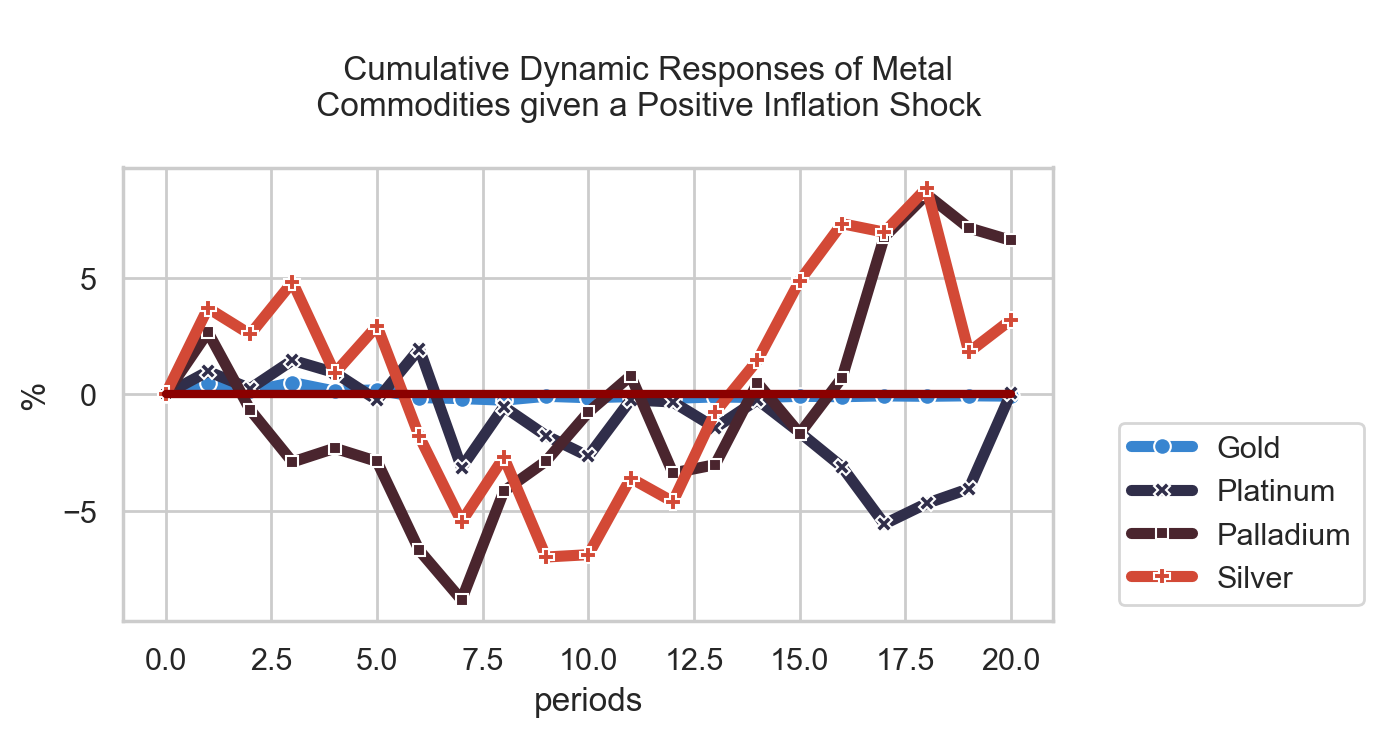

In [79]:
graph_responses(metal_commodities_final,'inflation','Metal','Inflation')

#### Dynamic Responses Interest Rate

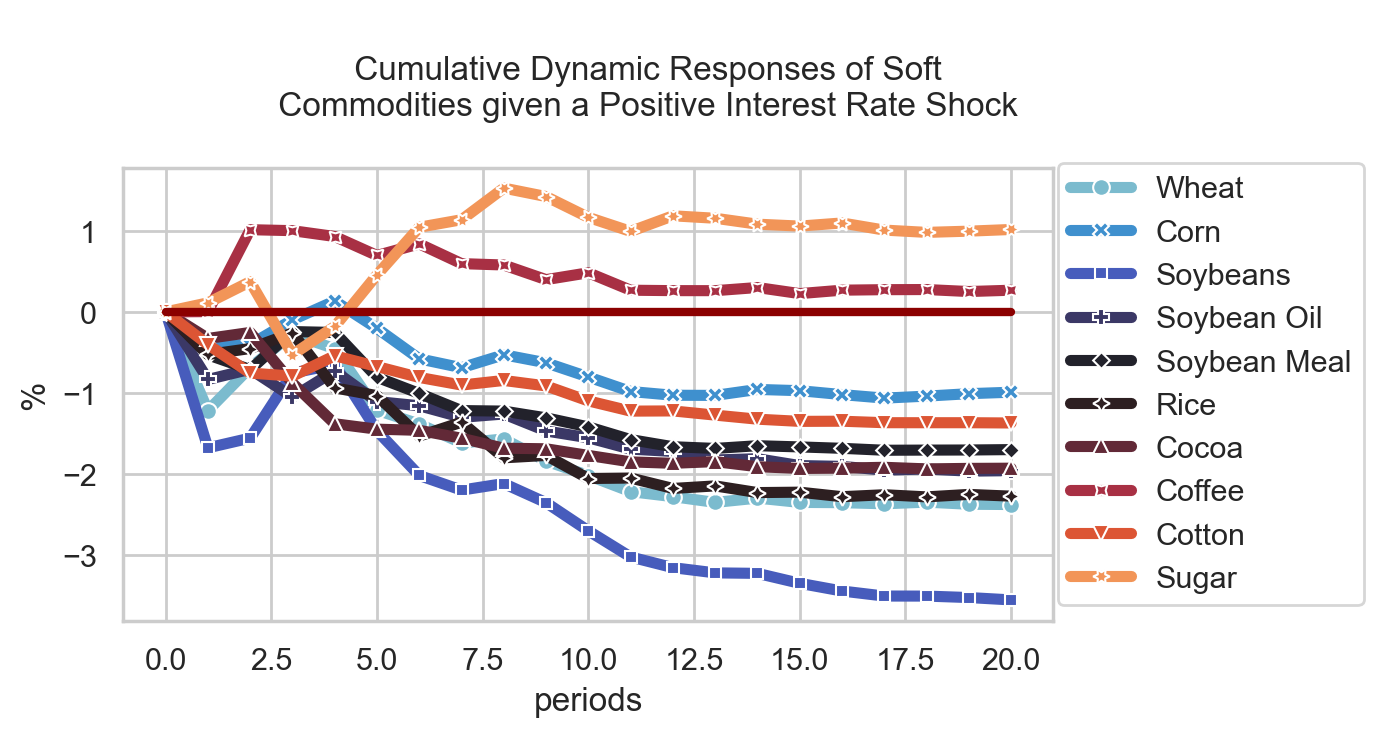

In [80]:
graph_responses(soft_commodities_final,'int_rate','Soft','Interest Rate')

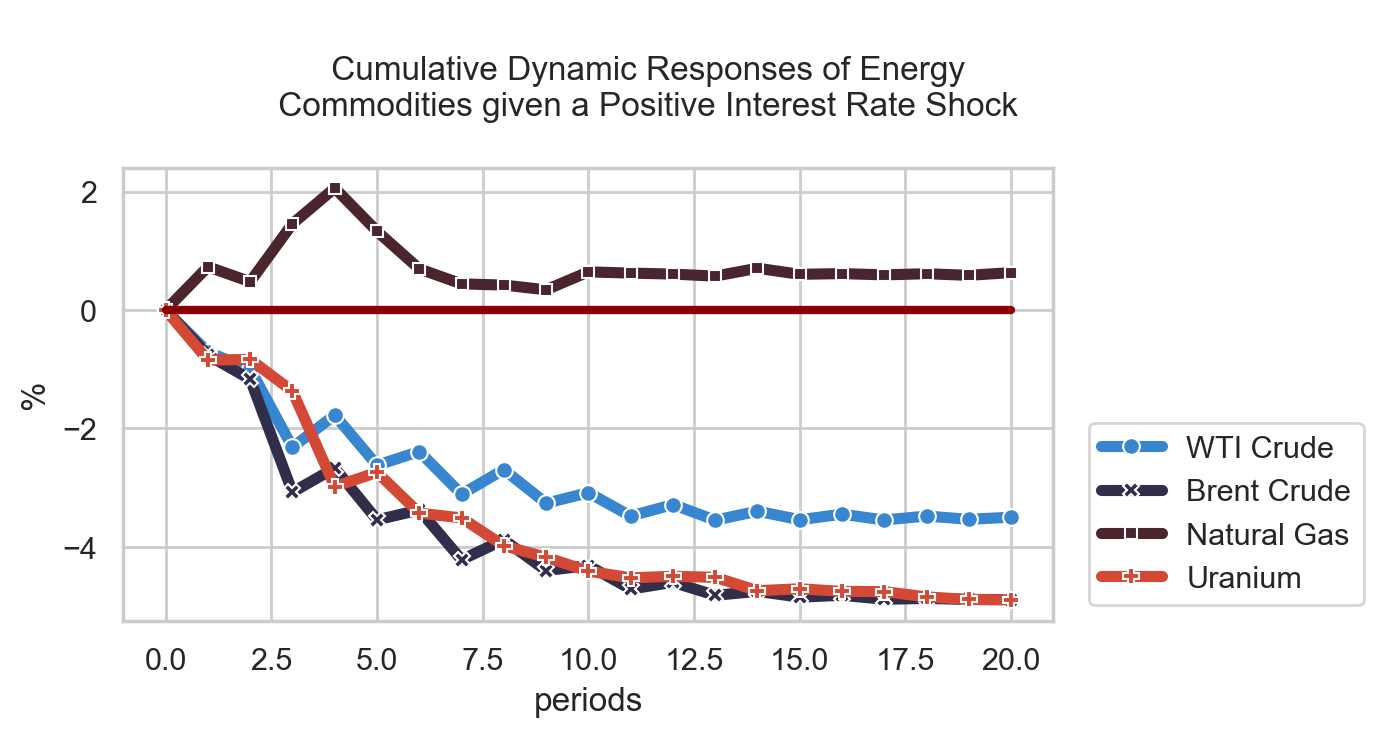

In [81]:
graph_responses(energy_commodities_final,'int_rate','Energy','Interest Rate')

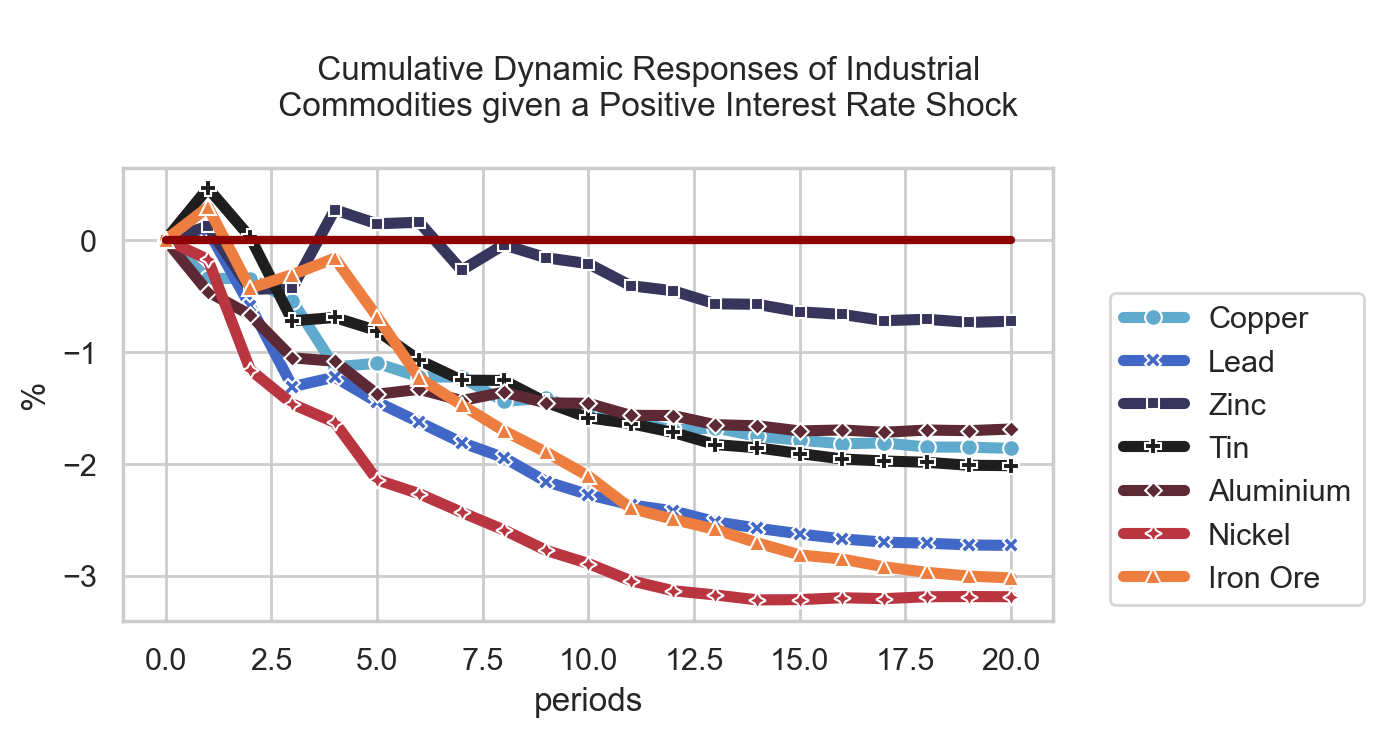

In [82]:
graph_responses(industrial_commodities_final,'int_rate','Industrial','Interest Rate')

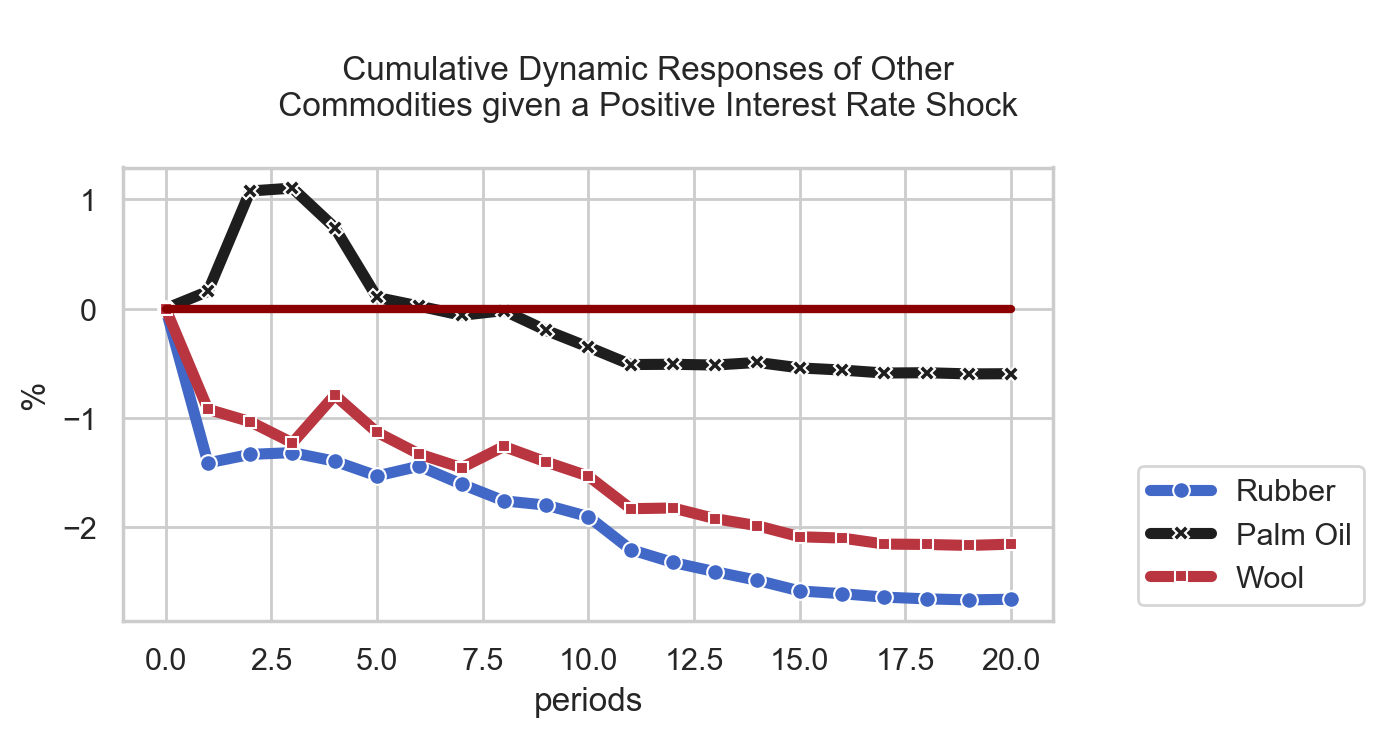

In [83]:
graph_responses(other_commodities_final,'int_rate','Other','Interest Rate')

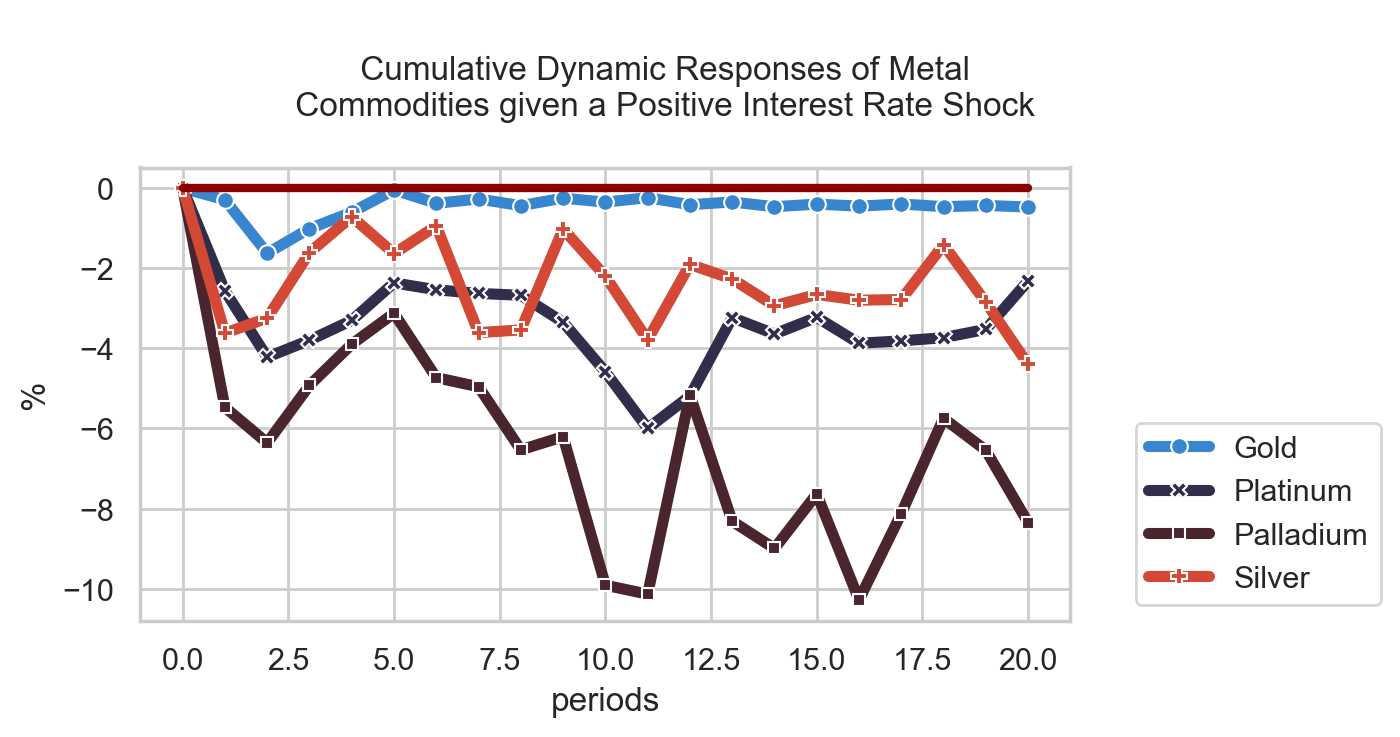

In [84]:
graph_responses(metal_commodities_final,'int_rate','Metal','Interest Rate')

#### Significance of Each Shock in the Variance of Commodity prices FEVD) Forecast Error Variance Decomposition

In [85]:
def get_fevd(df):
    
    tmp_col = df.drop(
          columns=['date','OECD_gdp_growth',
           'OECD_inflation','US_int_rate'])
    commodity_fevd = []
    gdp_growth_fevd = []
    inflation_fevd = []
    int_rate_fevd = []
    
    for comm in tmp_col:
        model = VAR(df[[comm,'OECD_gdp_growth',
                  'OECD_inflation','US_int_rate']])
        results = model.fit(maxlags=11, ic='aic')
        fevd = results.fevd(21)
        c_fevd = [fevd.decomp[0][k][0] for k in range(21)]
        g_fevd = [fevd.decomp[0][k][1] for k in range(21)]
        i_fevd = [fevd.decomp[0][k][2] for k in range(21)]
        ir_fevd = [fevd.decomp[0][k][3] for k in range(21)]
        commodity_fevd.append(c_fevd)
        gdp_growth_fevd.append(g_fevd)
        inflation_fevd.append(i_fevd)
        int_rate_fevd.append(ir_fevd)
        
    fevd_df = pd.DataFrame([pd.DataFrame(commodity_fevd).mean().to_list(),
                        pd.DataFrame(gdp_growth_fevd).mean().to_list(),
                        pd.DataFrame(inflation_fevd).mean().to_list(),
                        pd.DataFrame(int_rate_fevd).mean().to_list()],).T.rename(
                        columns={0:'Commodity',1:'GDP Growth',
                        2:'Inflation',3:'Interest Rates'}
                        )
    return fevd_df       


In [112]:
def graph_FEVD(df,type):
    df_fevd  = get_fevd(df)
    plt.figure(dpi=200)
    sns.set_theme(style="white")

    ax1 = df_fevd.plot(kind='bar', stacked=True, figsize=(12,6),
         fontsize=20, legend=True, colormap='icefire')
    ax1.legend(loc=2,fontsize=20)
    ax1.set_xlabel('periods',fontdict={'fontsize':20})
    ax1.set_title(f'FEVD of {type} Commodities',pad=10, fontdict={'fontsize':30})
    ax1.set_xticklabels(df_fevd.index, rotation=360)
    ax1.legend(loc=3,fontsize=20)


<Figure size 1200x800 with 0 Axes>

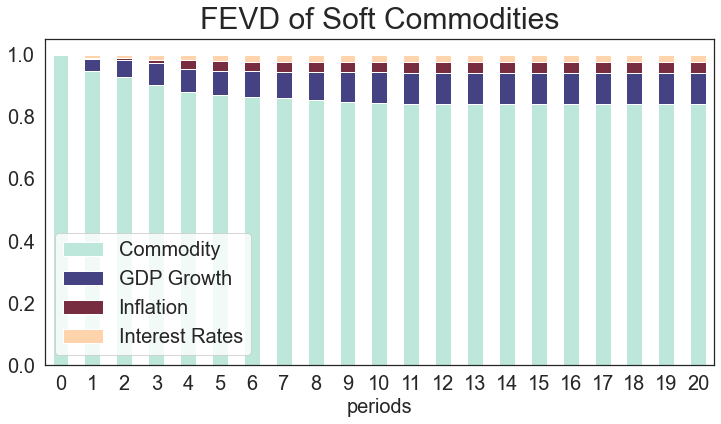

In [113]:
graph_FEVD(soft_commodities_final,'Soft') 

<Figure size 1200x800 with 0 Axes>

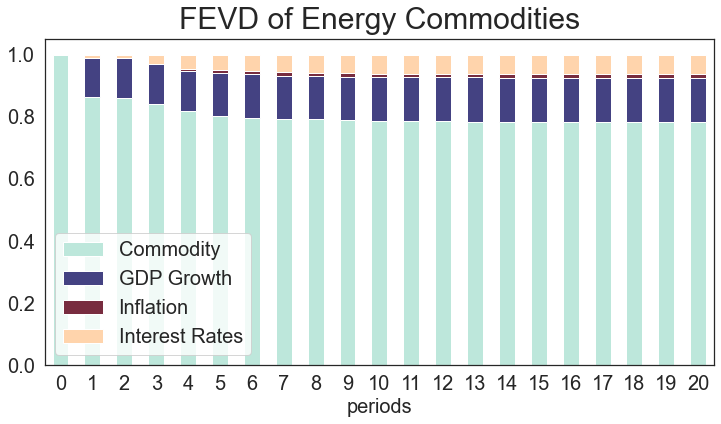

In [114]:
graph_FEVD(energy_commodities_final,'Energy')

<Figure size 1200x800 with 0 Axes>

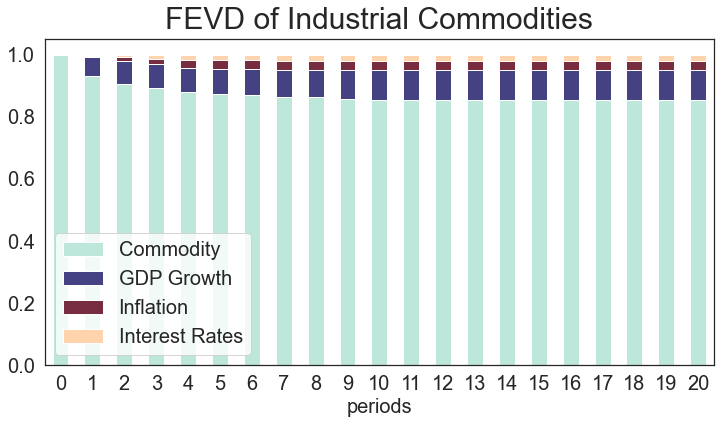

In [115]:
graph_FEVD(industrial_commodities_final,'Industrial')

<Figure size 1200x800 with 0 Axes>

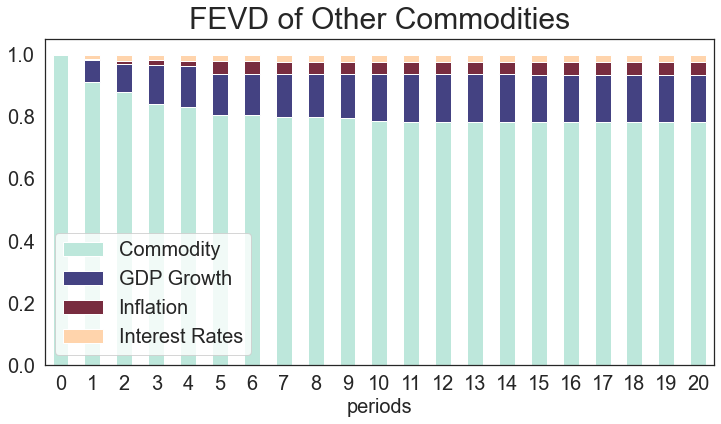

In [116]:
graph_FEVD(other_commodities_final,'Other')

<Figure size 1200x800 with 0 Axes>

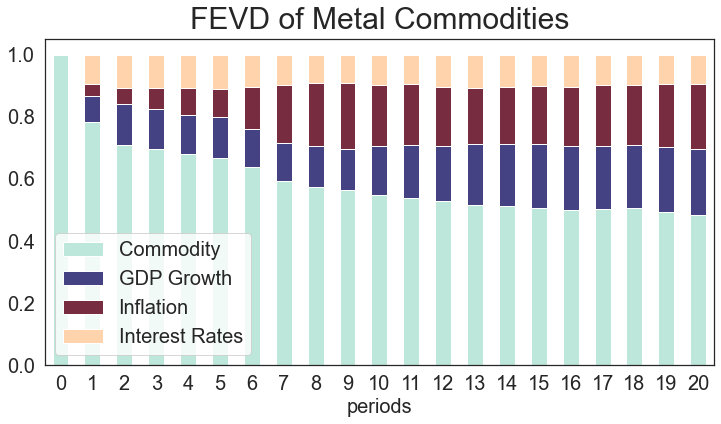

In [117]:
graph_FEVD(metal_commodities_final,'Metal')